In [ ]:
!git clone https://github.com/jy0205/Pyramid-Flow.git

!mv /content/Pyramid-Flow/* /

!rm -rf /content/Pyramid-Flow

In [ ]:
!pip install contexttimer decord diffusers>=0.30.1 accelerate==0.30.0 torch==2.1.2 torchvision==0.16.2 numpy==1.24.4 einops ftfy ipython opencv-python-headless==4.10.0.84 imageio==2.33.1 imageio-ffmpeg==0.5.1 packaging pandas plotly pre-commit pycocoevalcap pycocotools python-magic scikit-image sentencepiece spacy streamlit timm==0.6.12 tqdm transformers==4.39.3 wheel tensorboardX

# ***Download model to local folder***

In [5]:
%%capture
from huggingface_hub import snapshot_download

model_path = '/content/models'   # The local directory to save downloaded checkpoint
snapshot_download("rain1011/pyramid-flow-sd3", local_dir=model_path, local_dir_use_symlinks=False, repo_type='model')

In [10]:
import torch

# Load the 768p DiT model
diffusion_transformer_768p = torch.load('models/diffusion_transformer_768p/diffusion_pytorch_model.bin', map_location='cuda')

# Save the 768p DiT model
save_file(diffusion_transformer_768p, 'models/diffusion_transformer_768p/diffusion_pytorch_model.safetensors')

# Load the 384p DiT model
causal_video_vae = torch.load('models/diffusion_transformer_384p/diffusion_pytorch_model.bin', map_location='cuda')


# Save the 384p DiT model
save_file(causal_video_vae, 'models/diffusion_transformer_384p/diffusion_pytorch_model.safetensors')

# Load the vae model
causal_video_vae = torch.load('models/causal_video_vae/diffusion_pytorch_model.bin', map_location='cuda')

# Save the vae model
save_file(causal_video_vae, 'models/causal_video_vae/diffusion_pytorch_model.safetensors')

In [5]:
# used for 384p model variant
#width = 640
#height = 384
#variant='diffusion_transformer_384p'

# used for 768p model variant
width = 1280
height = 768
variant='diffusion_transformer_768p'         # For high resolution

temp = 16   # temp in [1, 31] <=> frame in [1, 241] <=> duration in [0, 10s]


In [6]:
import torch
from IPython.display import Video
from IPython.display import display
from PIL import Image
from pyramid_dit import PyramidDiTForVideoGeneration
from diffusers.utils import load_image, export_to_video
model_path = '/content/models'
torch.cuda.set_device(0)
model_dtype, torch_dtype = 'bf16', torch.bfloat16   # Use bf16, fp16 or fp32


model = PyramidDiTForVideoGeneration(
    model_path,                                         # The downloaded checkpoint dir
    model_dtype,
    model_variant=variant,     # 'diffusion_transformer_384p'
)

model.vae.to("cuda")
model.dit.to("cuda")
model.text_encoder.to("cuda")
model.vae.enable_tiling()


using half precision
Using temporal causal attention
We interp the position embedding of condition latents


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The latent dimmension channes is 16
The start sigmas and end sigmas of each stage is Start: {0: 1.0, 1: 0.8002399489209289, 2: 0.5007496155411024}, End: {0: 0.6669999957084656, 1: 0.33399999141693115, 2: 0.0}, Ori_start: {0: 1.0, 1: 0.6669999957084656, 2: 0.33399999141693115}


Load model

In [7]:
prompt = "A litter of golden retriever puppies playing in the snow. Their heads pop out of the snow."

with torch.no_grad(), torch.cuda.amp.autocast(enabled=True, dtype=torch_dtype):
    frames = model.generate(
        prompt=prompt,
        num_inference_steps=[20, 20, 20],
        video_num_inference_steps=[10, 10, 10],
        height=height,
        width=width,
        temp=temp,                    # temp=16: 5s, temp=31: 10s
        guidance_scale=7.0,         # The guidance for the first frame, set it to 7 for 384p variant
        video_guidance_scale=5.0,   # The guidance for the other video latent
        output_type="pil",
        save_memory=True,           # If you have enough GPU memory, set it to `False` to improve vae decoding speed
    )

export_to_video(frames, "./text_to_video_sample.mp4", fps=24)
# If the video is in Google Drive
Video('text_to_video_sample.mp4', embed=True, width=640, height=384)

100%|██████████| 16/16 [05:33<00:00, 20.83s/it]


# **Prompt to Video**

In [8]:
prompt = "A movie trailer featuring the adventures of the 30 year old space man wearing a red wool knitted motorcycle helmet, blue sky, salt desert, cinematic style, shot on 35mm film, vivid colors"


model.vae.enable_tiling()

with torch.no_grad(), torch.cuda.amp.autocast(enabled=True if model_dtype != 'fp32' else False, dtype=torch_dtype):
    frames = model.generate(
        prompt=prompt,
        num_inference_steps=[20, 20, 20],
        video_num_inference_steps=[10, 10, 10],
        height=height,
        width=width,
        temp=temp,
        guidance_scale=9.0,         # The guidance for the first frame, set it to 7 for 384p variant
        video_guidance_scale=5.0,   # The guidance for the other video latent
        output_type="pil",
        save_memory=True,           # If you have enough GPU memory, set it to `False` to improve vae decoding speed
    )

export_to_video(frames, "./text_to_video_sample.mp4", fps=24)
Video('text_to_video_sample.mp4', embed=True, width=640, height=384)

100%|██████████| 16/16 [01:04<00:00,  4.05s/it]


# ***Image to Video ***

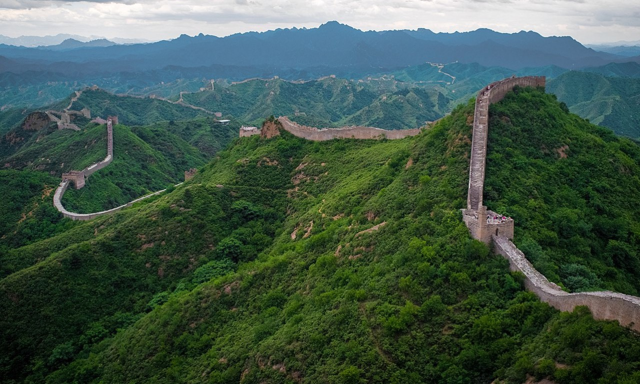

100%|██████████| 16/16 [01:04<00:00,  4.05s/it]


In [35]:
image_path = 'assets/the_great_wall.jpg'
image = Image.open(image_path).convert("RGB")

image = image.resize((width, height))

display(image)

prompt = "FPV flying over the Great Wall"

with torch.no_grad(), torch.cuda.amp.autocast(enabled=True if model_dtype != 'fp32' else False, dtype=torch_dtype):
    frames = model.generate_i2v(
        prompt=prompt,
        input_image=image,
        num_inference_steps=[10, 10, 10],
        temp=temp,
        guidance_scale=7.0,
        video_guidance_scale=4.0,
        output_type="pil",
        save_memory=False,         # If you have enough GPU memory, set it to `False` to improve vae decoding speed
    )

export_to_video(frames, "./image_to_video_sample.mp4", fps=24)
Video('image_to_video_sample.mp4', embed=True, width=640, height=384)